# Workshop #4. Statistical analysis of bulk RNA-seq

### Daniil Bobrovskiy, tg @daniilbobrovskiy

## Introduction

In this tutorial, we will analyze the bulk RNA-seq data from Walker et al., Scientific reports 2019 ([10.1038/s41598-019-56955-1](https://doi.org/10.1038/s41598-019-56955-1)). The goal of this study was to evaluate the changes in gene expression that occur during fibroblast to myofibroblast transdifferentiation in lungs. This transdifferentiation is known to occur in asthma and other lung diseases. Since it is also known that TGF-β can cause this process, the authors treated a culture of human lung fibroblasts with TGF-β to induce transdifferentiation.

The data consists of 12 samples from the cultured cells: 6 treated and 6 untreated with TGF-β. In each group, 3 samples were sequenced at day 1 after seeding cells and treating with TGF-β, while 3 other samples - at day 10.

Let's download the count matrix, which was already preprocessed by the authors, from the Gene Expression Omnibus (GEO).

It is important to note that a proper way to analyse RNA-seq data is to quantify the level of expression of different transcripts separately. After that, if the relative abundance of different isoforms is not of primary interest, the data can be aggregated to the gene-wise level, taking isoform lengths into account.

There is an amazing tool to perform this aggregation, no matter which transcript quantification tool you have used. It is an R library **tximport**, which **you should always use in your RNA-seq analysis**. Its tutorial tells you how to import quantification results from different tools (salmon/kallisto/RSEM/...) and how to pass tximport resuts into downstream libraries for differential expression analysis (edgeR/DESeq2/limma-voom): https://bioconductor.org/packages/release/bioc/vignettes/tximport/inst/doc/tximport.html.

However, the authors of the paper have simply calculated the counts for different genes and we will have to use this data in our tutorial.

In [2]:
# download data
!wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE110nnn/GSE110021/suppl/GSE110021%5Fcounts.Aug2015.txt.gz

# unzip count matrices
!gunzip GSE110021_counts.Aug2015.txt.gz

--2024-06-09 21:46:08--  https://ftp.ncbi.nlm.nih.gov/geo/series/GSE110nnn/GSE110021/suppl/GSE110021%5Fcounts.Aug2015.txt.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.11, 130.14.250.12, 2607:f220:41e:250::12, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1067815 (1.0M) [application/x-gzip]
Saving to: ‘GSE110021_counts.Aug2015.txt.gz’

GSE110021_counts.Au 100%[===================>]   1.02M  3.20MB/s    in 0.3s    

2024-06-09 21:46:09 (3.20 MB/s) - ‘GSE110021_counts.Aug2015.txt.gz’ saved [1067815/1067815]

gzip: GSE110021_counts.Aug2015.txt already exists; do you wish to overwrite (y or n)? ^C


Now, we will install and load the required packages. One of them is Rpy2, which allows us to work in R from GoogleColab. Actually, it even allows to pass the objects between Python and R, but we won't use this feature in this tutorial.

In [3]:
!echo "deb http://security.ubuntu.com/ubuntu focal-security main" | sudo tee /etc/apt/sources.list.d/focal-security.list
!apt-get update
!apt-get install libgmp3-dev libcairo2-dev libharfbuzz-dev libfribidi-dev libssl1.1

!pip install --upgrade gdown
!gdown 1XAbJa_suP-WFTKK628oM9EWsV7k-6fI9
!gdown 1Bt4HDrZqFId_7Ph99pSvhfFHxyrV-kaL
!tar xf library.tar.gz

deb http://security.ubuntu.com/ubuntu focal-security main
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [53.5 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [917 kB]
Get:8 http://security.ubuntu.com/ubuntu focal-security InRelease [128 kB]
Hit:9 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,885 kB]
Get:12 https://ppa.launchpadcontent.net/deadsnakes/

In [4]:
%load_ext rpy2.ipython
%R .libPaths("usr/local/lib/R/site-library/")
!Rscript -e 'install.packages("statmod")'
!Rscript -e 'install.packages("VennDiagram")'

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
trying URL 'https://cran.rstudio.com/src/contrib/statmod_1.5.0.tar.gz'
Content type 'application/x-gzip' length 92486 bytes (90 KB)
downloaded 90 KB

* installing *source* package ‘statmod’ ...
** package ‘statmod’ successfully unpacked and MD5 sums checked
** using staged installation
** libs
using C compiler: ‘gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0’
using Fortran compiler: ‘GNU Fortran (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0’
gcc -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -ffile-prefix-map=/build/r-base-H8urij/r-base-4.4.0=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c expectedDeviance.c -o expectedDeviance.o
gfortran  -fpic  -g -O2 -ffile-prefix-map=/build/r-base-H8urij/r-base-4.4.0=. -fstack-protector-strong  -c gaussq2.f -o gaussq2.o
gcc -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -ffile-prefix-map=/build/r-base-H8urij/r-base-4.4.

In [5]:
%%R

suppressPackageStartupMessages({
  library(ggplot2)
  library(ggrepel)
  library(stringr)
  library(dplyr)
  library(edgeR)
})

## Differential expression in edgeR

Another preprocessing step that is often done prior to DE analysis is the removal of all non-coding RNAs. If you want to do it, the easiest way is to load the transcript annotations corresponding to your transcriptome/genome versions from BioMart (https://www.ensembl.org/info/data/biomart/index.html). Often, if your data were mapped using not the latest annotation version, you should first go to Ensembl Archive (https://www.ensembl.org/info/website/archives/index.html), find a matching version and open BioMart from there.

In BioMart, you should select "Gene type" in the desired exported attributes together with the IDs needed to match your data to the resulting table. Once you obtained the table, you can simply filter your dataset to contain only "protein_coding" genes.

In addition to that, it is often desirable to convert unreadable ENSEMBL IDs to conventional gene names. This can be done by including the "Gene name" attribute to the BioMart export.

In [19]:
%%R
# load data; since the authors didn't merge the lanes, we'll have to do it ourselves
counts <- read.table("GSE110021_counts.Aug2015.txt")
counts <- data.frame(D1_cont_1=rowSums(select(counts, starts_with("D1.noTGFb.1"))),
                     D1_cont_2=rowSums(select(counts, starts_with("D1.noTGFb.2"))),
                     D1_cont_3=rowSums(select(counts, starts_with("D1.noTGFb.3"))),
                     D1_tgf_1=rowSums(select(counts, starts_with("D1.TGFb.1"))),
                     D1_tgf_2=rowSums(select(counts, starts_with("D1.TGFb.2"))),
                     D1_tgf_3=rowSums(select(counts, starts_with("D1.TGFb.3"))),
                     D20_cont_1=rowSums(select(counts, starts_with("D20.noTGFb.1"))),
                     D20_cont_2=rowSums(select(counts, starts_with("D20.noTGFb.2"))),
                     D20_cont_3=rowSums(select(counts, starts_with("D20.noTGFb.3"))),
                     D20_tgf_1=rowSums(select(counts, starts_with("D20.TGFb.1"))),
                     D20_tgf_2=rowSums(select(counts, starts_with("D20.TGFb.2"))),
                     D20_tgf_3=rowSums(select(counts, starts_with("D20.TGFb.3"))))

In [20]:
%%R

str(counts)

'data.frame':	25702 obs. of  12 variables:
 $ D1_cont_1 : num  51 0 0 0 1 0 2 0 0 14 ...
 $ D1_cont_2 : num  66 0 0 0 2 0 0 0 0 13 ...
 $ D1_cont_3 : num  42 0 0 0 1 0 0 0 0 14 ...
 $ D1_tgf_1  : num  29 0 0 0 1 0 0 0 0 11 ...
 $ D1_tgf_2  : num  52 0 0 0 2 0 0 0 0 19 ...
 $ D1_tgf_3  : num  37 0 0 0 1 0 0 0 0 11 ...
 $ D20_cont_1: num  41 0 0 0 1 0 2 0 0 10 ...
 $ D20_cont_2: num  48 0 0 0 0 0 2 0 0 19 ...
 $ D20_cont_3: num  67 0 0 0 3 1 0 0 0 18 ...
 $ D20_tgf_1 : num  82 0 0 0 0 0 1 0 0 16 ...
 $ D20_tgf_2 : num  35 0 0 0 3 0 0 0 0 9 ...
 $ D20_tgf_3 : num  39 0 0 0 1 0 0 0 0 2 ...


Let's load the table I pre-downloaded from BioMart

In [21]:
%%R
biomart <- read.table("biomart_hg19_ensembl75.tsv", sep="\t", header=TRUE)
str(biomart)

'data.frame':	233303 obs. of  7 variables:
 $ Gene.stable.ID                    : chr  "ENSG00000261657" "ENSG00000261657" "ENSG00000261657" "ENSG00000261657" ...
 $ Gene.stable.ID.version            : chr  "ENSG00000261657.1" "ENSG00000261657.1" "ENSG00000261657.1" "ENSG00000261657.1" ...
 $ Transcript.stable.ID              : chr  "ENST00000566782" "ENST00000562780" "ENST00000569579" "ENST00000568242" ...
 $ Transcript.stable.ID.version      : chr  "ENST00000566782.1" "ENST00000562780.1" "ENST00000569579.1" "ENST00000568242.1" ...
 $ NCBI.gene..formerly.Entrezgene..ID: int  115286 115286 115286 115286 115286 NA NA NA NA 100873766 ...
 $ Gene.name                         : chr  "SLC25A26" "SLC25A26" "SLC25A26" "SLC25A26" ...
 $ Gene.type                         : chr  "protein_coding" "protein_coding" "protein_coding" "protein_coding" ...


In [22]:
%%R
protein_coding <- biomart$Gene.type[match(rownames(counts), biomart$NCBI.gene..formerly.Entrezgene..ID)] == "protein_coding"
protein_coding[is.na(protein_coding)] <- FALSE
counts <- counts[protein_coding,]
ensembl <- biomart$Gene.stable.ID[match(rownames(counts), biomart$NCBI.gene..formerly.Entrezgene..ID)]
symbol <- biomart$Gene.name[match(rownames(counts), biomart$NCBI.gene..formerly.Entrezgene..ID)]
str(counts)

'data.frame':	19016 obs. of  12 variables:
 $ D1_cont_1 : num  0 0 0 3 1394 ...
 $ D1_cont_2 : num  0 0 0 27 1522 ...
 $ D1_cont_3 : num  0 0 0 4 1281 ...
 $ D1_tgf_1  : num  0 0 0 14 954 109 23 9 11 131 ...
 $ D1_tgf_2  : num  0 0 0 26 1861 ...
 $ D1_tgf_3  : num  0 0 0 11 920 92 25 4 11 133 ...
 $ D20_cont_1: num  0 0 0 15 680 113 26 4 20 230 ...
 $ D20_cont_2: num  0 0 0 32 865 169 26 6 27 329 ...
 $ D20_cont_3: num  0 0 0 14 999 182 40 11 25 384 ...
 $ D20_tgf_1 : num  0 0 0 40 1187 ...
 $ D20_tgf_2 : num  0 0 0 22 681 103 30 4 5 202 ...
 $ D20_tgf_3 : num  0 0 0 11 700 133 35 3 6 174 ...


In [23]:
%%R

str(ensembl)

 chr [1:19016] "ENSG00000186092" "ENSG00000235249" "ENSG00000235249" ...


Let's use principal component analysis to visualize overall differences between our samples

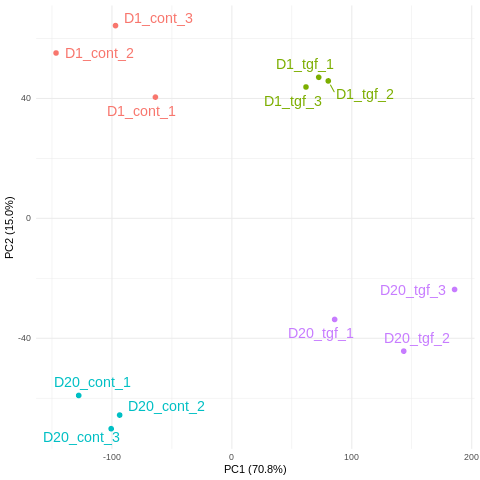

In [24]:
%%R
# scale the data
counts_scaled <- t(scale(counts))

# run PCA
pca_result <- prcomp(counts_scaled, center = TRUE, scale. = TRUE)
variance_explained <- pca_result$sdev^2 / sum(pca_result$sdev^2) * 100

# extract first two PCs
scores_df <- data.frame(PC1 = pca_result$x[,1], PC2 = pca_result$x[,2])
scores_df$Sample = row.names(scores_df)
groups <- str_remove(scores_df$Sample, "_[0-9]+$")
scores_df$group = groups

# plot first two PCs
ggplot(scores_df, aes(x = PC1, y = PC2, label = Sample, color = group)) +
  geom_point(size=2) +
  geom_text_repel(size=5,
                  box.padding = 0.5,
                  point.padding = 0.5,
                  max.overlaps = Inf)+
  theme_minimal()+
  theme(legend.position = "none")+
  labs(x=paste("PC1 (", sprintf("%.1f", variance_explained[1]), "%)", sep=""),,
       y=paste("PC2 (", sprintf("%.1f", variance_explained[2]), "%)", sep=""),)

Loading our counts into edgeR and adding information about the groups

In [25]:
%%R
y <- DGEList(counts=counts, group=groups)
design <- model.matrix(~0+groups)
colnames(design) <- str_remove(colnames(design), "groups")
design

   D1_cont D1_tgf D20_cont D20_tgf
1        1      0        0       0
2        1      0        0       0
3        1      0        0       0
4        0      1        0       0
5        0      1        0       0
6        0      1        0       0
7        0      0        1       0
8        0      0        1       0
9        0      0        1       0
10       0      0        0       1
11       0      0        0       1
12       0      0        0       1
attr(,"assign")
[1] 1 1 1 1
attr(,"contrasts")
attr(,"contrasts")$groups
[1] "contr.treatment"



Filtering low-expressed genes

In [26]:
%%R
keep <- filterByExpr(y, design=design, min.count=10, min.total.count=100, min.prop=0.25)
y <- y[keep, , keep.lib.sizes=FALSE]
y$genes <- data.frame(Ensembl=ensembl, Symbol=symbol)
str(y)

Formal class 'DGEList' [package "edgeR"] with 1 slot
  ..@ .Data:List of 3
  .. ..$ : num [1:12354, 1:12] 3 1394 164 27 12 ...
  .. .. ..- attr(*, "dimnames")=List of 2
  .. .. .. ..$ : chr [1:12354] "148398" "26155" "339451" "84069" ...
  .. .. .. ..$ : chr [1:12] "D1_cont_1" "D1_cont_2" "D1_cont_3" "D1_tgf_1" ...
  .. ..$ :'data.frame':	12 obs. of  3 variables:
  .. .. ..$ group       : Factor w/ 4 levels "D1_cont","D1_tgf",..: 1 1 1 2 2 2 3 3 3 4 ...
  .. .. ..$ lib.size    : num [1:12] 11351867 14429978 11359967 8538244 17891947 ...
  .. .. ..$ norm.factors: num [1:12] 1 1 1 1 1 1 1 1 1 1 ...
  .. ..$ :'data.frame':	19016 obs. of  2 variables:
  .. .. ..$ Ensembl: chr [1:19016] "ENSG00000186092" "ENSG00000235249" "ENSG00000235249" "ENSG00000187634" ...
  .. .. ..$ Symbol : chr [1:19016] "OR4F5" "OR4F29" "OR4F29" "SAMD11" ...
  ..$ names: chr [1:3] "counts" "samples" "genes"


Compute effective library sizes (see lecture)

In [27]:
%%R
y <- calcNormFactors(y) # called normLibSizes in newer versions
str(y)

Formal class 'DGEList' [package "edgeR"] with 1 slot
  ..@ .Data:List of 3
  .. ..$ : num [1:12354, 1:12] 3 1394 164 27 12 ...
  .. .. ..- attr(*, "dimnames")=List of 2
  .. .. .. ..$ : chr [1:12354] "148398" "26155" "339451" "84069" ...
  .. .. .. ..$ : chr [1:12] "D1_cont_1" "D1_cont_2" "D1_cont_3" "D1_tgf_1" ...
  .. ..$ :'data.frame':	12 obs. of  3 variables:
  .. .. ..$ group       : Factor w/ 4 levels "D1_cont","D1_tgf",..: 1 1 1 2 2 2 3 3 3 4 ...
  .. .. ..$ lib.size    : num [1:12] 11351867 14429978 11359967 8538244 17891947 ...
  .. .. ..$ norm.factors: num [1:12] 1.013 1.029 1.015 0.973 0.965 ...
  .. ..$ :'data.frame':	19016 obs. of  2 variables:
  .. .. ..$ Ensembl: chr [1:19016] "ENSG00000186092" "ENSG00000235249" "ENSG00000235249" "ENSG00000187634" ...
  .. .. ..$ Symbol : chr [1:19016] "OR4F5" "OR4F29" "OR4F29" "SAMD11" ...
  ..$ names: chr [1:3] "counts" "samples" "genes"


Compared to what we discussed in the lecture, the variance of the counts in edgeR has a slightly more complicated form. It contains both the common dispersion component for all of the genes $\phi$, and the gene-wise dispersion component $\sigma_g$:

$Var(y_{ig}) = σ^2_g(\mu_{ig} + \phi \mu^2_{ig}),$ $i$ - sample, $g$ - gene.

First, the common dispersion $\phi$ is evaluated. Then, the trend for the gene-wise dispersions is computed as discussed in the lecture. Finally, the gene-wise dispersions are estimated and squeezed towards that trend.

In [28]:
%%R
y <- estimateDisp(y, design)
# this is equivalent to:
# y <- estimateGLMCommonDisp(y, design)
# y <- estimateGLMTrendedDisp(y, desig
# y <- estimateGLMTagwiseDisp(y, design)

Now let's tell edgeR, which groups we want to compare

In [29]:
%%R
fit <- glmQLFit(y, design)
contrasts <- makeContrasts(
  cont_20vs1 = D20_cont - D1_cont,
  tgf_20vs1 = D20_tgf - D1_tgf,
  d1_tgf = D1_tgf - D1_cont,
  d20_tgf = D20_tgf - D20_cont,
  levels=design)

In [30]:
%%R
contrasts

          Contrasts
Levels     cont_20vs1 tgf_20vs1 d1_tgf d20_tgf
  D1_cont          -1         0     -1       0
  D1_tgf            0        -1      1       0
  D20_cont          1         0      0      -1
  D20_tgf           0         1      0       1


For example, the contrast `cont_20vs1` signifies a statistical test for the null hypothesis that `D20_cont - D1_cont = 0`.

In [31]:
%%R
qlf_cont_20vs1 <- glmQLFTest(fit, contrast=contrasts[,"cont_20vs1"])
qlf_tgf_20vs1 <- glmQLFTest(fit, contrast=contrasts[,"tgf_20vs1"])
qlf_d1_tgf <- glmQLFTest(fit, contrast=contrasts[,"d1_tgf"])
qlf_d20_tgf <- glmQLFTest(fit, contrast=contrasts[,"d20_tgf"])

In [32]:
%%R
print(summary(decideTests(qlf_cont_20vs1)))
print(summary(decideTests(qlf_tgf_20vs1)))
print(summary(decideTests(qlf_d1_tgf)))
print(summary(decideTests(qlf_d20_tgf)))

       -1*D1_cont 1*D20_cont
Down                    2884
NotSig                  6468
Up                      3002
       -1*D1_tgf 1*D20_tgf
Down                  2928
NotSig                6524
Up                    2902
       -1*D1_cont 1*D1_tgf
Down                  1364
NotSig                9665
Up                    1325
       -1*D20_cont 1*D20_tgf
Down                    2469
NotSig                  7539
Up                      2346


The smallest number of DE genes is found between the TGF-β-treated and untreated cells on day 1, which is expected.

In [33]:
%%R
qlftab_cont_20vs1 <- topTags(qlf_cont_20vs1, n=nrow(y))$table
qlftab_tgf_20vs1 <- topTags(qlf_tgf_20vs1, n=nrow(y))$table
qlftab_d1_tgf <- topTags(qlf_d1_tgf, n=nrow(y))$table
qlftab_d20_tgf <- topTags(qlf_d20_tgf, n=nrow(y))$table

In [34]:
%%R
head(qlftab_cont_20vs1)

              Ensembl   Symbol     logFC   logCPM        F       PValue
6328  ENSG00000103018    CYB5B  5.912420 2.421628 596.3106 6.715974e-13
6574  ENSG00000159625  CCDC135 -1.631513 8.349429 578.4268 8.277230e-13
25907 ENSG00000141524     TMC6 -1.623484 8.716842 466.0209 3.632401e-12
9700  ENSG00000023191     RNH1 -2.758252 3.685243 451.7046 4.494145e-12
10212 ENSG00000186073 C15orf41 -1.630497 5.433907 408.9434 8.846526e-12
991   ENSG00000142733   MAP3K6 -3.224106 5.439792 404.8024 9.480323e-12
               FDR
6328  5.112845e-09
6574  5.112845e-09
25907 1.388017e-08
9700  1.388017e-08
10212 1.707764e-08
991   1.707764e-08


Let's visualize, which DE genes are common between different comparisons

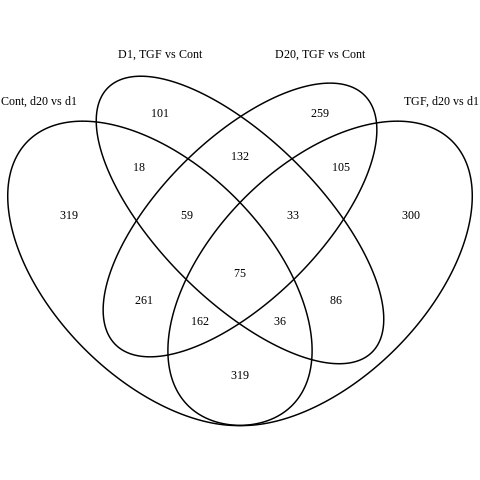

In [35]:
%%R
# Filter DE Genes based on FDR < 0.05 and logFC > 2
de_genes_cont_20vs1 <- subset(qlftab_cont_20vs1, FDR < 0.05 & abs(logFC) > 1)$Symbol
de_genes_tgf_20vs1 <- subset(qlftab_tgf_20vs1, FDR < 0.05 & abs(logFC) > 1)$Symbol
de_genes_d1_tgf <- subset(qlftab_d1_tgf, FDR < 0.05 & abs(logFC) > 1)$Symbol
de_genes_d20_tgf <- subset(qlftab_d20_tgf, FDR < 0.05 & abs(logFC) > 1)$Symbol

# Use VennDiagram package to plot the Venn diagram
library(VennDiagram)
venn.plot <- venn.diagram(
  x = list(
    Cont_20vs1 = de_genes_cont_20vs1,
    TGF_20vs1 = de_genes_tgf_20vs1,
    D1_TGF = de_genes_d1_tgf,
    D20_TGF = de_genes_d20_tgf
  ),
  category.names = c("Cont, d20 vs d1", "TGF, d20 vs d1", "D1, TGF vs Cont", "D20, TGF vs Cont"),
  filename = NULL
)
grid.draw(venn.plot)

And now we plot a **volcano plot** for one of the comparisons! This is useful to identify genes which have both large changes in expression (large logFC) and these changes are significant (large -log10(P-value)).

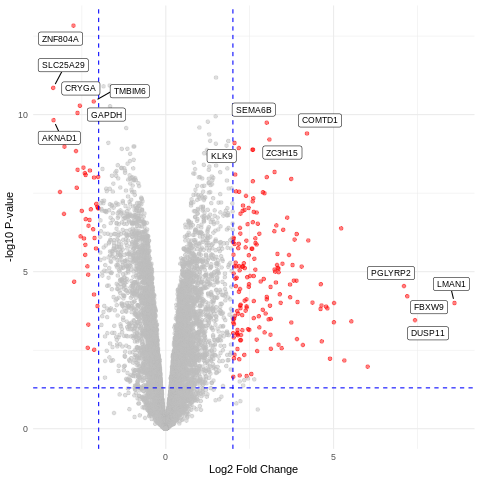

In [ ]:
%%R
# ad
qlftab_tgf_20vs1$p_log10 <- -log10(qlftab_tgf_20vs1$PValue)

# Identify the most DE genes: (abs(logFC)>2 and -log10P>9) or (abs(logFC)>7)
top_genes <- qlftab_tgf_20vs1[((abs(qlftab_tgf_20vs1$logFC)>2)&(qlftab_tgf_20vs1$p_log10>9))|(abs(qlftab_tgf_20vs1$logFC)>7), ]

# Plot the volcano plot
ggplot(qlftab_tgf_20vs1, aes(x=logFC, y=p_log10)) +
  geom_point(aes(color = (FDR < 0.05 & abs(logFC) > 2)), alpha=0.5) +
  scale_color_manual(values = c("FALSE" = "grey", "TRUE" = "red")) +
  labs(x = "Log2 Fold Change",
       y = "-log10 P-value") +
  theme_minimal() +
  theme(legend.title = element_blank(), legend.position = "none") +
  geom_vline(xintercept = c(-2, 2), linetype = "dashed", color = "blue") +
  geom_hline(yintercept = -log10(0.05), linetype = "dashed", color = "blue") +
  geom_label_repel(data = top_genes,
                  aes(label = Symbol),
                  size = 3,
                  box.padding = unit(0.35, "lines"),
                  point.padding = unit(0.5, "lines"))

Finally, we can perform gene set enrichment analysis for this comparison using clusterProfiler package

In [ ]:
%%R
suppressPackageStartupMessages({
  library(clusterProfiler)
  library(org.Hs.eg.db)
})

In [ ]:
%%R
geneList <- qlftab_tgf_20vs1$p_log10*sign(qlftab_tgf_20vs1$logFC)
names(geneList) <- rownames(qlftab_tgf_20vs1)
geneList <- sort(geneList, decreasing = TRUE)

gsea_bp <- gseGO(geneList=geneList, ont="BP", OrgDb=org.Hs.eg.db)

In [ ]:
%%R

head(gsea_bp@result[, c("Description", "setSize", "NES", "p.adjust")])

                                                     Description setSize
GO:0006261                         DNA-templated DNA replication     159
GO:0006260                                       DNA replication     270
GO:0090329           regulation of DNA-templated DNA replication      54
GO:0098813                        nuclear chromosome segregation     267
GO:0045005 DNA-templated DNA replication maintenance of fidelity      54
GO:0007059                                chromosome segregation     325
                 NES     p.adjust
GO:0006261 -2.877053 7.671831e-09
GO:0006260 -2.656880 7.671831e-09
GO:0090329 -2.630386 7.671831e-09
GO:0098813 -2.618211 7.671831e-09
GO:0045005 -2.607404 7.671831e-09
GO:0007059 -2.605617 7.671831e-09


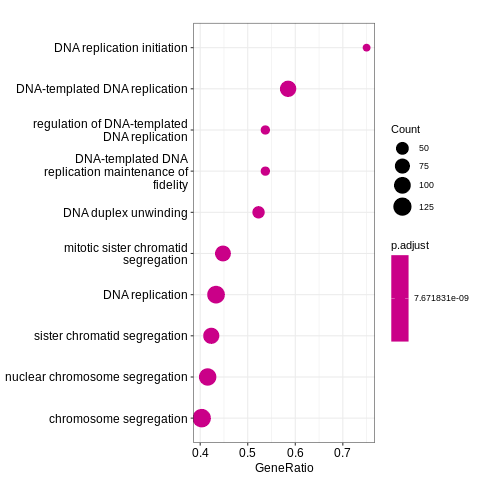

In [ ]:
%%R
dotplot(gsea_bp, showCategory=10)

## Exercise

At home, perform the same analysis with the standard DESeq2 pipeline. DESeq2 documentation is very detailed: https://www.bioconductor.org/packages/release/bioc/vignettes/DESeq2/inst/doc/DESeq2.html. For each step, comment, how it relates to what we did in edgeR.

You can then compare lists of differentially expressed genes between edgeR and DESeq2 using Venn diagrams or plot the p-values of different genes in edgeR and DESeq2 against each other.

And feel free to ask questions! @daniilbobrovskiy

In [6]:
%%R
suppressPackageStartupMessages(library(DESeq2))

Примерный план:

1. Составляем матрицу каунтов для начала и причесываем датасет точно так же как для edgeR.

2. PCA разложение как для edgeR.

3. Составим табличку meta_data с указанием, к какой группе относится столбец наблюдений.

4. Создадим датасет DESeq на основе матрицы каунтов и метаинформации.

5. Запускаем анализ. Судя по туториалу DESeq2, подбор размера библиотеки и оценка дисперсии происходит внутри без необходимости отдельного запуска. Чтобы указать, какие группы нас интересуют, указываем группы в значениях result.

6. Рисуем диаграмму Эйлера-Венна!

In [7]:
%%R

#матрица каунтов

count_matrix <- read.table("GSE110021_counts.Aug2015.txt")
count_matrix <- data.frame(D1_cont_1=rowSums(select(count_matrix, starts_with("D1.noTGFb.1"))),
                            D1_cont_2=rowSums(select(count_matrix, starts_with("D1.noTGFb.2"))),
                            D1_cont_3=rowSums(select(count_matrix, starts_with("D1.noTGFb.3"))),
                            D1_tgf_1=rowSums(select(count_matrix, starts_with("D1.TGFb.1"))),
                            D1_tgf_2=rowSums(select(count_matrix, starts_with("D1.TGFb.2"))),
                            D1_tgf_3=rowSums(select(count_matrix, starts_with("D1.TGFb.3"))),
                            D20_cont_1=rowSums(select(count_matrix, starts_with("D20.noTGFb.1"))),
                            D20_cont_2=rowSums(select(count_matrix, starts_with("D20.noTGFb.2"))),
                            D20_cont_3=rowSums(select(count_matrix, starts_with("D20.noTGFb.3"))),
                            D20_tgf_1=rowSums(select(count_matrix, starts_with("D20.TGFb.1"))),
                            D20_tgf_2=rowSums(select(count_matrix, starts_with("D20.TGFb.2"))),
                            D20_tgf_3=rowSums(select(count_matrix, starts_with("D20.TGFb.3"))))

In [8]:
%%R

#скачиваем информацию о белках

gene_anno <- read.table("biomart_hg19_ensembl75.tsv", sep = '\t', header = TRUE)

In [9]:
#причесываем
%%R

protein_coding <- gene_anno$Gene.type[match(rownames(count_matrix), gene_anno$NCBI.gene..formerly.Entrezgene..ID)] == "protein_coding"
protein_coding[is.na(protein_coding)] <- FALSE
count_matrix <- count_matrix[protein_coding,]
ensembl <- gene_anno$Gene.stable.ID[match(rownames(count_matrix), gene_anno$NCBI.gene..formerly.Entrezgene..ID)]
symbol <- gene_anno$Gene.name[match(rownames(count_matrix), gene_anno$NCBI.gene..formerly.Entrezgene..ID)]

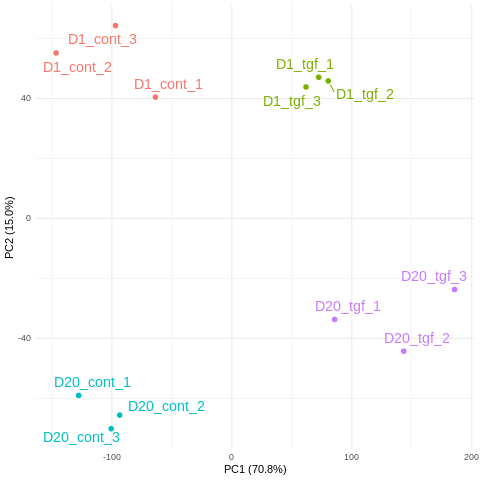

In [10]:
%%R

#разложение PCA
# scale the data
counts_scaled <- t(scale(count_matrix))

# run PCA
pca_result <- prcomp(counts_scaled, center = TRUE, scale. = TRUE)
variance_explained <- pca_result$sdev^2 / sum(pca_result$sdev^2) * 100

# extract first two PCs
scores_df <- data.frame(PC1 = pca_result$x[,1], PC2 = pca_result$x[,2])
scores_df$Sample = row.names(scores_df)
groups <- str_remove(scores_df$Sample, "_[0-9]+$")
scores_df$group = groups

# plot first two PCs
ggplot(scores_df, aes(x = PC1, y = PC2, label = Sample, color = group)) +
  geom_point(size=2) +
  geom_text_repel(size=5,
                  box.padding = 0.5,
                  point.padding = 0.5,
                  max.overlaps = Inf)+
  theme_minimal()+
  theme(legend.position = "none")+
  labs(x=paste("PC1 (", sprintf("%.1f", variance_explained[1]), "%)", sep=""),,
       y=paste("PC2 (", sprintf("%.1f", variance_explained[2]), "%)", sep=""),)

In [11]:
%%R

#строим таблицу meta data

meta_data <- data.frame(colnames(count_matrix), groups)

In [12]:
#создадим датасет DEseq2 на основе матрицы каунтов и метаинформации
%%R

dataset <- DESeqDataSetFromMatrix(countData = count_matrix,           #тут данные
                                  colData = meta_data,                #здесь информация, какими свойствами описываются колонки
                                  design= ~ groups                    #здесь столбец из meta_data, по которому будем группировать при анализе
                                  )

In [13]:
%%R

dataset

class: DESeqDataSet 
dim: 19016 12 
metadata(1): version
assays(1): counts
rownames(19016): 79501 729759 ... 442868 9085
rowData names(0):
colnames(12): D1_cont_1 D1_cont_2 ... D20_tgf_2 D20_tgf_3
colData names(2): colnames.count_matrix. groups


In [14]:
%%R
#фильтрация редких белков, может, тут ее и не нужно делать
smallestGroupSize <- 3
keep <- rowSums(counts(dataset) >= 10) >= smallestGroupSize
dataset <- dataset[keep,]

In [15]:
%%R
#запускаем DESeq2 анализ!
dataset2 <- DESeq(dataset)

In [16]:
%%R
#результаты получаем для разных групп, нужные группы указаны вот тут внизу
result_D1_cont_VS_tgf <- results(dataset2, contrast=c("groups","D1_cont","D1_tgf"))
result_D20_cont_VS_tgf <- results(dataset2, contrast=c("groups", "D20_cont", "D20_tgf"))
result_Cont_D1_VS_D20 <- results(dataset2, contrast=c("groups", "D1_cont", "D20_cont"))
result_TGF_D1_VS_D20 <- results(dataset2, contrast=c("groups", "D1_tgf", "D20_tgf"))

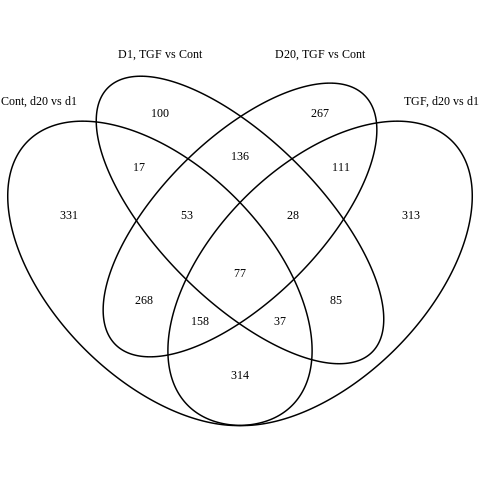

In [18]:
%%R
#строим диаграмму эйлера венна аналогично тому, как мы это делали на семинаре
de_genes_cont_20vs1 <- row.names(subset(result_Cont_D1_VS_D20, padj < 0.05 & log2FoldChange > 1))
de_genes_tgf_20vs1 <- row.names(subset(result_TGF_D1_VS_D20, padj < 0.05 & log2FoldChange > 1))
de_genes_d1_tgf <- row.names(subset(result_D1_cont_VS_tgf, padj < 0.05 & log2FoldChange > 1))
de_genes_d20_tgf <- row.names(subset(result_D20_cont_VS_tgf, padj < 0.05 & log2FoldChange > 1))

# Use VennDiagram package to plot the Venn diagram
library(VennDiagram)
venn.plot <- venn.diagram(
  x = list(
    Cont_20vs1 = de_genes_cont_20vs1,
    TGF_20vs1 = de_genes_tgf_20vs1,
    D1_TGF = de_genes_d1_tgf,
    D20_TGF = de_genes_d20_tgf
  ),
  category.names = c("Cont, d20 vs d1", "TGF, d20 vs d1", "D1, TGF vs Cont", "D20, TGF vs Cont"),
  filename = NULL
)
grid.draw(venn.plot)

In [ ]:
%%R

result_TGF_D1_VS_D20

log2 fold change (MLE): groups D1_tgf vs D20_tgf 
Wald test p-value: groups D1_tgf vs D20_tgf 
DataFrame with 12606 rows and 6 columns
         baseMean log2FoldChange     lfcSE      stat      pvalue        padj
        <numeric>      <numeric> <numeric> <numeric>   <numeric>   <numeric>
148398   17.28364      -0.308683 0.5670020 -0.544413 5.86157e-01 6.93376e-01
26155  1067.00087       0.710960 0.0840601  8.457761 2.72561e-17 1.32639e-15
339451  154.99217       0.214653 0.1659877  1.293188 1.95946e-01 3.01772e-01
84069    34.58942       0.157649 0.3053253  0.516332 6.05622e-01 7.09279e-01
84808     8.02696       0.536617 0.6221524  0.862516 3.88403e-01 5.12718e-01
...           ...            ...       ...       ...         ...         ...
7411    879.18533      0.4302526  0.102002  4.218087 2.46384e-05 1.34260e-04
116442   18.05568     -3.8974705  0.581535 -6.702034 2.05538e-11 3.79853e-10
1193     35.65483     -1.5493335  0.333782 -4.641759 3.45456e-06 2.29582e-05
55217   120.95363 